In [14]:
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
MAX_CAR = 20
Y = 0.9 # DISCOUNT
CREDICT_REWARD = 10
MOVING_REWARD = -2

In [3]:
def poissons(mu, ranges):
    out = []
    tot = 0
    for r in range(ranges+1):
        p = poisson.pmf(r, mu=mu)
        tot += p
        out.append(p)

    out = [p/tot for p in out]

    return out


In [4]:
poissons(2, 6)

[0.13595166163141997,
 0.27190332326283995,
 0.27190332326283995,
 0.18126888217522658,
 0.09063444108761329,
 0.03625377643504533,
 0.012084592145015099]

In [5]:
# Initialization
req_1 = poissons(3, 7)
req_2 = poissons(4, 9)
ret_1 = poissons(3, 7)
ret_2 = poissons(2, 6)

In [6]:
req_1

[0.0503868994061544,
 0.15116069821846323,
 0.2267410473276948,
 0.2267410473276948,
 0.17005578549577113,
 0.10203347129746275,
 0.051016735648731326,
 0.021864315278027714]

In [11]:
# expected reward

def expected_reward(cur_state, action, value):
    """
    state  : It's a pair of integers, # of cars at A and at B
    action : # of cars transferred from A to B,  -5 <= action <= 5 
    """

    reward = 0
    new_state = [max(min(cur_state[0]-action, MAX_CAR), 0), 
                 max(min(cur_state[1]+action, MAX_CAR), 0)]
    
    # adding reward for moving cars from one location to another
    reward += MOVING_REWARD * abs(action)

    for cur_rq1 in range(len(req_1)):
        for cur_rq2 in range(len(req_2)):
            for cur_rt1 in range(len(ret_1)):
                for cur_rt2 in range(len(ret_2)):
                    # calculate the prob
                    cur_prob = req_1[cur_rq1] * req_2[cur_rq2] * ret_1[cur_rt1] * ret_2[cur_rt2]

                    valid_requests_A = min(new_state[0], cur_rq1)
                    valid_requests_B = min(new_state[1], cur_rq2)

                    cur_reward = (valid_requests_A + valid_requests_B) * CREDICT_REWARD
                    next_state = [min(max(new_state[0]-cur_rq1+cur_rt1, 0), MAX_CAR),
                                  min(max(new_state[1]-cur_rq2+cur_rt2, 0), MAX_CAR)]
                    
                    # Bellman equation
                    reward += cur_prob * (cur_reward + Y*value[next_state[0]][next_state[1]])

    return reward

In [8]:
# policy evaluation

def policy_evaluation(value, policy, elpsilon):    
    while(True):
        sigma = 0
        
        val_copy = value.copy()
        for i in range(len(value[0])):
            for j in range(len(value[1])):
                # value[i][j] denotes the value of the state [i,j]
                
                old_val = value[i][j]
                value[i][j] = expected_reward([i,j], policy[i][j], val_copy)
                
                sigma = max(sigma, abs(value[i][j] - old_val))
                
                print('.', end = '')
                sys.stdout.flush()

        print(sigma)
        sys.stdout.flush()
    
        if sigma < elpsilon:
            break

    return value, policy, elpsilon/10

In [9]:
# policy improvement
def policy_improvement(value, policy):
    policy_stable = True
    for i in range(len(value[0])):
        for j in range(len(value[1])):
            old_action = policy[i][j]

            max_act_val = 0
            max_act = 0

            p12 = min(i,5)       # if I have say 3 cars at the first location, then I can atmost move 3 from 1 to 2
            p21 = -min(j,5)      # if I have say 2 cars at the second location, then I can atmost move 2 from 2 to 1
            
            for a in range(p21, p12+1):
                cur_val = expected_reward([i,j], a, value)
                if max_act_val < cur_val:
                    max_act_val = cur_val
                    max_act = a
            
            policy[i][j] = max_act

            if old_action != policy[i][j]:
                policy_stable = False
    
    return value, policy, policy_stable

In [12]:
value = np.zeros((MAX_CAR+1, MAX_CAR+1))
policy = value.copy().astype(int)
elp = 50

while True:
    value, policy, elp = policy_evaluation(value, policy, elp)
    value, policy, stb = policy_improvement(value, policy)
    if stb:
        break

..

.......................................................................................................................................................................................................................................................................................................................................................................................................................................................68.81048361558149
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................61.9294352540235
.....................................................................................

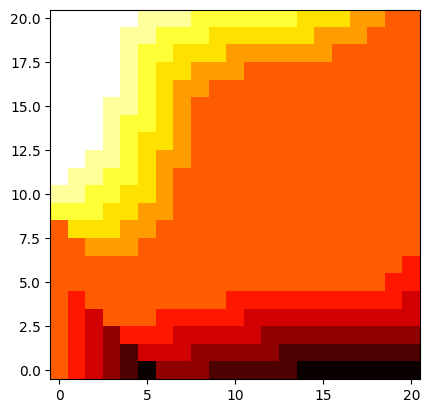

In [16]:
plt.imshow(policy, cmap='hot', interpolation='nearest')
plt.gca().invert_yaxis()
plt.show()